# Grado en Robótica - Visión Artificial
## Práctica 4: Modelos de salencia espectrais e a súa avaliación
### Autor: Adrián Losada Álvarez

# Tarea 1: Saliencia estática

### Importamos las librerías necesarias

In [13]:
#Importamos las librerias precisas
import cv2
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pySaliencyMap
import scipy.io as sio
import math
import pandas as pd
import os

# Intentamos empregar a fft2 do modulo pyfftw se esta dispoñible
try:
    from pyfftw.interfaces.scipy_fftpack import fft2, ifft2
# De outra forma, executarase scipy fftpack(~2-3x mais lenta!)
except ImportError:
    import warnings
    warnings.warn("""Modulo 'pyfftw' (FFTW Python bindings) sen intalar. Executa 'pip install pyfftw' no teu entorno""")
    from scipy.fftpack import fft2, ifft2

### A continuación, se implementan dos funciones que se utilizarán en los métodos posteriores.

In [ ]:
# Función para obtener el mapa de saliencia binarizado
def SMGetBinarizedSM(sm):
    # Si no hay mapa de saliencia, lo creamos
    if sm is None:
        print("Error, mapa de saliencia aportado no válido.")

    # Convertimos la escala
    SM_I8U = np.uint8(255 * sm)

    # Binarizamos
    thresh, bin_sm = cv2.threshold(SM_I8U, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    return bin_sm

# Función para obtener la región saliente según el mapa de saliencia binarizado
def SMGetSalientRegion(img, bin_sm):
    # Si no hay mapa de saliencia binarizado, se imprime un mensaje de error
    if bin_sm is None:
        print("Error: mapa de saliencia binarizado no válido.")
        return None

    # Convertir la imagen a CV_8UC3
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)

    # Crear la máscara de segmentación
    mask = np.where((bin_sm != 0), cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')
    bgdmodel = np.zeros((1, 65), np.float64)
    fgdmodel = np.zeros((1, 65), np.float64)

    # Definir el rectángulo de interés
    rect = (0, 0, img.shape[1]-1, img.shape[0]-1)

    # Ejecutar GrabCut
    cv2.grabCut(img, mask=mask, rect=rect, bgdModel=bgdmodel, fgdModel=fgdmodel, iterCount=5, mode=cv2.GC_INIT_WITH_MASK)

    # Post-procesamiento
    mask_out = np.where((mask == cv2.GC_FGD) + (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    output = cv2.bitwise_and(img, img, mask=mask_out)

    return output

### a) Creamos un algoritmo que calcule el mapa de salencia utilizando el método del residuo espectral (SR) (además le incluímos la información de color y la invarianza a la escala)

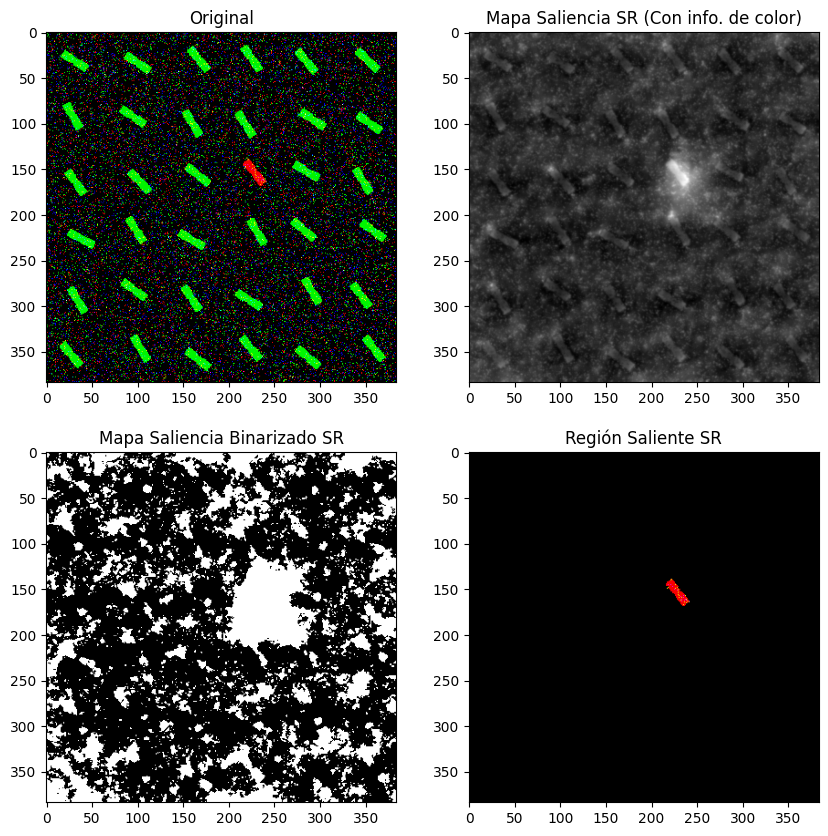

In [35]:
# Función para calcular el mapa de saliencia basado en el residuo espectral considerando información de color e invariante a la escala
def SR_Color_Multiescala(img, num_scales=5):
    # Si es una imagen en escala de grises, no podemos obtener información de los colores 
    if len(img.shape) == 2:
        print("Imagen en escala de grises, devolviendo la imagen original...")
        return img

    rows, cols = img.shape[0], img.shape[1]

    # Crear la pirámide gaussiana
    pyramid = [img]
    for _ in range(num_scales-1):
        img = cv2.pyrDown(img)
        pyramid.append(img)

    # Inicializar el mapa de saliencia final
    final_sm = np.zeros((rows, cols), dtype=np.float32)

    for scaled_img in pyramid:
        # Pasar de BGR a LAB
        imageLAB = cv2.cvtColor(scaled_img, cv2.COLOR_BGR2LAB)

        # Obtener los canales L, A, B
        L = imageLAB[:, :, 0]
        A = imageLAB[:, :, 1]
        B = imageLAB[:, :, 2]
        channels = [L, A, B]
        results = []

        # Para cada canal
        for i in range(len(channels)):
            # Transformada de Fourier para el canal actual
            c = cv2.dft(np.float32(channels[i]), flags=cv2.DFT_COMPLEX_OUTPUT)
            mag = np.sqrt(c[:, :, 0] ** 2 + c[:, :, 1] ** 2)
            spectralResidual = np.exp(np.log(mag) - cv2.boxFilter(np.log(mag), -1, (3, 3)))

            # Aplicación del residuo espectral al canal en el dominio de la frecuencia
            c[:, :, 0] = c[:, :, 0] * spectralResidual / mag
            c[:, :, 1] = c[:, :, 1] * spectralResidual / mag
            c = cv2.dft(c, flags=(cv2.DFT_INVERSE | cv2.DFT_SCALE))
            mag = c[:, :, 0] ** 2 + c[:, :, 1] ** 2

            # Suavizado y redimensionamiento para comparación
            sm = cv2.resize(cv2.GaussianBlur(mag, (3, 3), 0.8), (cols, rows), cv2.INTER_LANCZOS4)
            sm = cv2.normalize(sm, mag, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Calcular la varianza del mapa de saliencia del canal actual
            ###### PROBAR SIN ESTO: ######
            # (Combinarlo de manera normal, primero combinar los mapas de saliencia y después normalizar el mapa final)
            var = np.var(sm)

            # Ponderar el mapa de saliencia del canal actual en función de la varianza
            results.append(sm / (var + 1e-8))  # Se agrega un pequeño valor para evitar la división por cero

        # Normalizar las ponderaciones para que sumen 1
        weights = np.array(results) / np.sum(results, axis=0)

        # Sumar los mapas ponderados
        combined_result = np.sum(weights * np.array(results), axis=0)

        # Fusionar el mapa de saliencia actual con el mapa de saliencia final
        final_sm += combined_result

    # Normalizar el mapa de saliencia final
    final_sm /= num_scales

    return final_sm

# Cargar imagen
image = cv2.imread('test1.png', 1)

# Llamamos a la función para calcular el mapa de saliencia a multiescala con información de color e invariante a la escala
sm = SR_Color_Multiescala(image, num_scales=7)
bin_sm = SMGetBinarizedSM(sm)
salient_region = SMGetSalientRegion(image, bin_sm)

# Visualización
plt.figure(figsize=[10, 10])
plt.subplot(2, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(2, 2, 2), plt.imshow(sm, cmap='gray'), plt.title('Mapa Saliencia SR (Con info. de color)')
plt.subplot(2, 2, 3), plt.imshow(bin_sm, cmap='gray'), plt.title('Mapa Saliencia Binarizado SR')
plt.subplot(2, 2, 4), plt.imshow(salient_region), plt.title('Región Saliente SR')
plt.show()

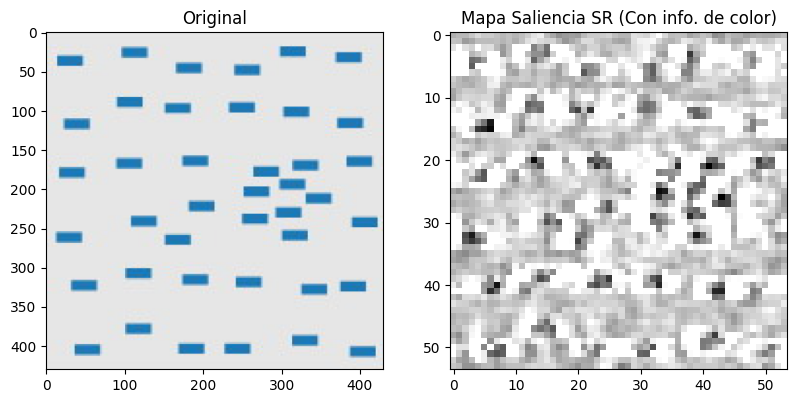

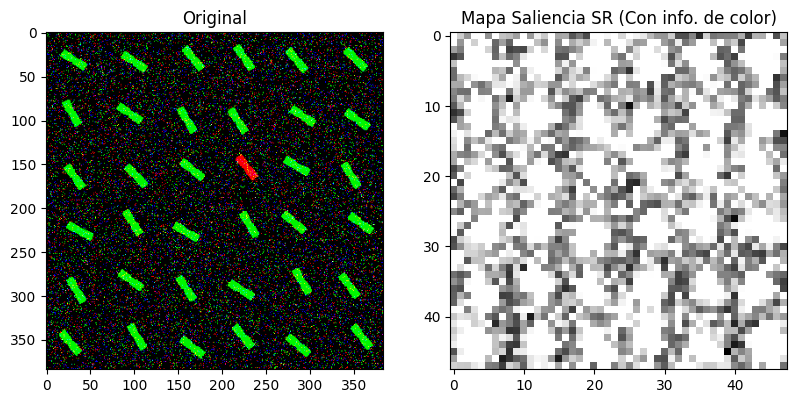

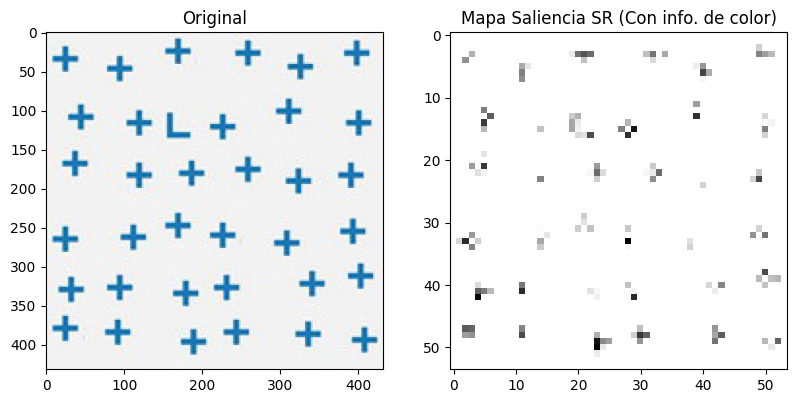

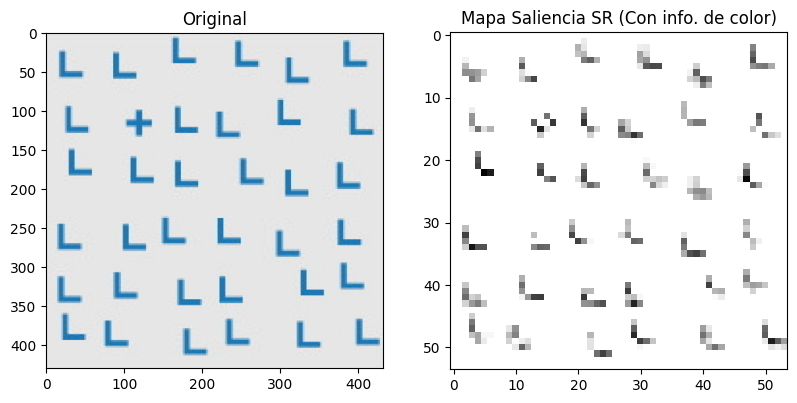

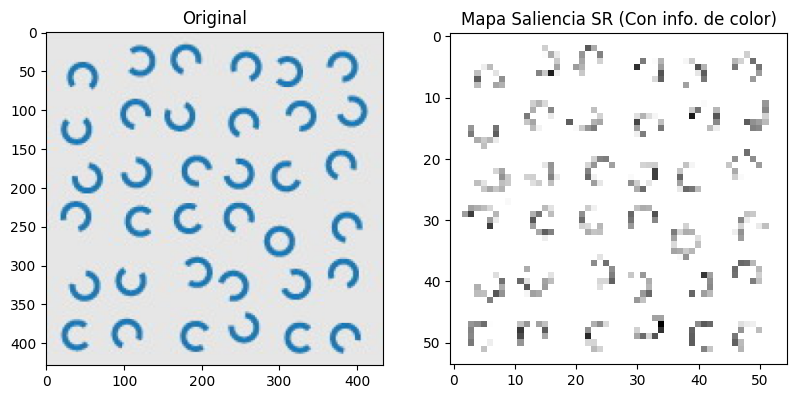

In [37]:
# Función para calcular el mapa de saliencia basado en el residuo espectral considerando información de color e invariante a la escala
def SR_Color_Multiescala(img, num_scales=5):
    # Si es una imagen en escala de grises, no podemos obtener información de los colores 
    if len(img.shape) == 2:
        print("Imagen en escala de grises, devolviendo la imagen original...")
        return img

    # Crear la pirámide gaussiana
    pyramid = [img]
    for _ in range(num_scales-1):
        img = cv2.pyrDown(img)
        pyramid.append(img)

    smSS = []

    for scaled_img in pyramid:
        rows, cols = img.shape[:2]

        # Pasar de BGR a LAB
        imageLAB = cv2.cvtColor(scaled_img, cv2.COLOR_BGR2LAB)

        # Obtener los canales L, A, B
        L = imageLAB[:, :, 0]
        A = imageLAB[:, :, 1]
        B = imageLAB[:, :, 2]
        channels = [L, A, B]
        results = []

        # Para cada canal
        for i in range(len(channels)):
            # Transformada de Fourier para el canal actual
            c = cv2.dft(np.float32(channels[i]), flags=cv2.DFT_COMPLEX_OUTPUT)
            mag = np.sqrt(c[:, :, 0] ** 2 + c[:, :, 1] ** 2)
            mag_log = np.log(mag + 1e-6)  # Agregar pequeño valor para evitar log(0)

            # Calcular el residuo espectral
            spectralResidual = np.exp(mag_log - cv2.boxFilter(mag_log, -1, (3, 3)))

            # Aplicar el residuo espectral al canal en el dominio de la frecuencia
            c[:, :, 0] = c[:, :, 0] * spectralResidual / mag
            c[:, :, 1] = c[:, :, 1] * spectralResidual / mag
            c = cv2.dft(c, flags=(cv2.DFT_INVERSE | cv2.DFT_SCALE))
            mag = c[:, :, 0] ** 2 + c[:, :, 1] ** 2

            # Suavizado y redimensionamiento para comparación
            sm = cv2.resize(cv2.GaussianBlur(mag, (3, 3), 0.8), (cols, rows), cv2.INTER_LANCZOS4)
            results.append(sm)

        # Sumar los mapas ponderados
        combined_channels = np.sum(np.array(results), axis=0)
        normalized_channels = cv2.normalize(combined_channels, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Almacenar el mapa de saliencia en la escala actual
        smSS.append(normalized_channels)

    # Reconstruir la imagen con las pirámides
    sm_ = smSS[-1]  # Iniciar con la imagen de la escala más baja
    for i in range(2, len(smSS) + 1):
        # Redimensionar la imagen de la pirámide para que coincida con las dimensiones de sm_
        smSS[-i] = cv2.resize(smSS[-i], (sm_.shape[1], sm_.shape[0]))
        # Sumar las imágenes de la pirámide invertida
        sm_ = cv2.add(sm_, smSS[-i])

    # Normalizar el mapa de saliencia final después de haber agregado todos los mapas
    final_sm = cv2.normalize(sm_, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return final_sm

# Cargar imagen
image = cv2.imread('test1.png')
dataPath = '../imaxes_pop-out_proba/'
imagesList = os.listdir(dataPath)

for imgName in imagesList:
    image = cv2.imread(dataPath+imgName, 1)
    # Llamamos a la función para calcular el mapa de saliencia a multiescala con información de color e invariante a la escala
    sm = SR_Color_Multiescala(image, num_scales=4)
    #bin_sm = SMGetBinarizedSM(sm)
    #salient_region = SMGetSalientRegion(image, bin_sm)

    # Visualización
    plt.figure(figsize=[20, 10])
    plt.subplot(1, 4, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(1, 4, 2), plt.imshow(sm, cmap='gray'), plt.title('Mapa Saliencia SR (Con info. de color)')
    #plt.subplot(1, 4, 3), plt.imshow(bin_sm, cmap='gray'), plt.title('Mapa Saliencia Binarizado SR')
    #plt.subplot(1, 4, 4), plt.imshow(salient_region), plt.title('Región Saliente SR')
    plt.show()

### b) Creamos un algoritmo que calcule el mapa de salencia utilizando el método de la fase global (PFT) (además le incluímos la información de color y la invarianza a la escala)

In [ ]:
# Función para calcular el mapa de saliencia basado en el espectro de fase de la transformada de Fourier
def PFT_Color_Multiescala(img, num_scales=5):
    # Si es una imagen en escala de grises, no podemos obtener información de los colores 
    if len(img.shape) == 2:
        print("Imagen en escala de grises, devolviendo la imagen original...")
        return img

    rows, cols = img.shape[0], img.shape[1]

    # Crear la pirámide gaussiana
    pyramid = [img]
    for _ in range(num_scales-1):
        img = cv2.pyrDown(img)
        pyramid.append(img)

    # Inicializar el mapa de saliencia final
    final_sm = np.zeros((rows, cols), dtype=np.float32)

    for scaled_img in pyramid:
        # Pasamos de BGR a LAB
        imageLAB = cv2.cvtColor(scaled_img, cv2.COLOR_BGR2LAB)

        # Obtenemos los canales L->blanco-negro (luminosidad), A->rojo-verde, B->azul-amarillo
        L = imageLAB[:,:,0]
        A = imageLAB[:,:,1]
        B = imageLAB[:,:,2]
        channels = [L, A, B]
        results = []

        # Para cada canal
        for i in range(len(channels)):
            # Transformada de Fourier
            img_fft = np.fft.fft2(channels[i])

            # Espectro de la fase de la imagen
            phase_espectrum = np.angle(img_fft)

            # Mapa de saliencia
            sm = cv2.GaussianBlur((np.abs(np.fft.ifft2(np.exp(1j * phase_espectrum)))**2), (3, 3), 1)

            # Redimensionamos y normalizamos el mapa de saliencia
            sm = cv2.normalize(cv2.resize(sm, (rows, cols), cv2.INTER_LANCZOS4), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Calcular la varianza del mapa de saliencia del canal actual
            ###### PROBAR SIN ESTO: ######
            # (Combinarlo de manera normal, primero combinar los mapas de saliencia y después normalizar el mapa final)
            var = np.var(sm)

            # Ponderar el mapa de saliencia del canal actual en función de la varianza
            results.append(sm / (var + 1e-8))   # Se agrega un pequeño valor para evitar la división por cero

        # Normalizar las ponderaciones para que sumen 1
        weights = np.array(results) / np.sum(results, axis=0)

        # Sumar los mapas ponderados
        combined_result = np.sum(weights * np.array(results), axis=0)

        # Fusionar el mapa de saliencia actual con el mapa de saliencia final
        final_sm += combined_result

    # Normalizar el mapa de saliencia final
    final_sm /= num_scales

    return final_sm


# Cargar imagen
image = cv2.imread('test1.png')
dataPath = '../imaxes_pop-out_proba/'
imagesList = os.listdir(dataPath)

for imgName in imagesList:
    image = cv2.imread(dataPath+imgName, 1)
    # Llamamos a la función para calcular el mapa de saliencia a multiescala con información de color e invariante a la escala
    sm = PFT_Color_Multiescala(image, num_scales=6)
    bin_sm = SMGetBinarizedSM(sm)
    salient_region = SMGetSalientRegion(image, bin_sm)

    # Visualización
    plt.figure(figsize=[20, 10])
    plt.subplot(1, 4, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(1, 4, 2), plt.imshow(sm, cmap='gray'), plt.title('Mapa Saliencia SR (Con info. de color)')
    plt.subplot(1, 4, 3), plt.imshow(bin_sm, cmap='gray'), plt.title('Mapa Saliencia Binarizado SR')
    plt.subplot(1, 4, 4), plt.imshow(salient_region), plt.title('Región Saliente SR')
    plt.show()

### c) Tras las lecturas de los documentos y el análisis del código de Itti et al aportados, podemos resumir los pasos para obtener el mapa de saliencia en:
**1. Extraer los mapas de características.**
- 1.1. Obtener los canales de color (R, G, B, I)
- 1.2. Extraer el mapa de características de la intensidad
- 1.3. Extraer el mapa de características de los colores (R-G y B-Y)
- 1.4. Extraer el mapa de características de las orientaciones (depende del número de orientaciones pero en nuestro ejemplo: 0º, 45º, 90º, 135º)

**2. Combinar los mapas de características para obtener el mapa de saliencia**
- 2.1. Normalizamos cada uno de los mapas de características
- 2.2. Sumamos los mapas normalizados multiplicados con el peso de cada uno (peso configurable)
- 2.3. Normalizamos el mapa de saliencia obtenido
- 2.4. Reajustamos el mapa de saliencia

#### Siguiendo estos pasos:

In [ ]:
# Función para obtener el mapa de saliencia binarizado
def binariza(sm):
    # Si no hay mapa de saliencia, lo creamos
    if sm is None:
        print("Error, mapa de saliencia aportado no válido.")

    # Convertimos la escala
    SM_I8U = np.uint8(255*sm)

    # Binarizamos
    thresh, bin_sm = cv2.threshold(SM_I8U, thresh=220, maxval=255, type=cv2.THRESH_BINARY)

    return bin_sm



# Cargar imagen
image = cv2.imread('test1.png')
dataPath = '../imaxes_pop-out_proba/'
imagesList = os.listdir(dataPath)

for imgName in imagesList:
    image = cv2.imread(dataPath+imgName, 1)

    # Inicialización
    image_width  = image.shape[1]
    image_height = image.shape[0]
    sm = pySaliencyMap.pySaliencyMap(image_width, image_height)

    # Computación
    saliency_map = sm.SMGetSM(image)
    bin_sm = binariza(saliency_map)
    salient_region = SMGetSalientRegion(image, bin_sm)

    # Visualización
    plt.figure(figsize=[20, 10])
    plt.subplot(1, 4, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(1, 4, 2), plt.imshow(saliency_map, cmap='gray'), plt.title('Mapa Saliencia')
    plt.subplot(1, 4, 3), plt.imshow(bin_sm, cmap='gray'), plt.title('Mapa Saliencia Binarizado')
    plt.subplot(1, 4, 4), plt.imshow(salient_region), plt.title('Región Saliente')
    plt.show()

### d) Para analizar los modelos del residuo espectral, fase global y el de Itti et al con las medidas vistas (AUC, NCC y CC), necesitaremos:
- Cargar la base de datos con las imágenes originales
- Cargar los mapas de fijación o "ground-truth"
- Crear las bases de datos con las respuestas de los métodos a analizar
- Desarrollar las funciones necesarias para calcular los valores de AUC, NCC y CC
- Mostrar los resultados y analizar

#### En primer lugar definiremos las funciones que crearán los mapas de saliencia:

In [ ]:
WIDTH = 64

# Funciones para aplicar los métodos
def SR(img):
    rows, cols = img.shape  # Obtener las dimensiones de la imagen original

    # Redimensionar la imagen manteniendo la proporción
    img = cv2.resize(img, (WIDTH, int(WIDTH * img.shape[0] / img.shape[1])))

    # Transformada de Fourier para convertir la imagen al dominio de la frecuencia
    c = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    mag = np.sqrt(c[:,:,0]**2 + c[:,:,1]**2)  # Calcular la magnitud en el dominio de la frecuencia
    spectralResidual = np.exp(np.log(mag) - cv2.boxFilter(np.log(mag), -1, (3,3)))  # Obtener el residuo espectral

    # Aplicar el residuo espectral al canal de frecuencia
    c[:,:,0] = c[:,:,0] * spectralResidual / mag
    c[:,:,1] = c[:,:,1] * spectralResidual / mag
    c = cv2.dft(c, flags=(cv2.DFT_INVERSE | cv2.DFT_SCALE))  # Transformada inversa para volver al dominio espacial
    mag = c[:,:,0]**2 + c[:,:,1]**2  # Obtener la magnitud de la imagen resultante

    # Aplicar un filtro gaussiano para suavizar la magnitud
    sm = cv2.resize(cv2.GaussianBlur(mag, (9,9), 3, 3), (cols, rows), cv2.INTER_LANCZOS4)

    # Normalizar la señal suavizada entre 0 y 255 utilizando la magnitud
    sm = (cv2.normalize(sm, mag, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)

    return sm  # Devolver la señal suavizada y normalizada

def PFT(img):
    rows, cols = img.shape  # Obtener las dimensiones de la imagen original

    # Redimensionar la imagen manteniendo la proporción
    img = cv2.resize(img, (WIDTH, int(WIDTH * img.shape[0] / img.shape[1])))

    # Transformada de Fourier
    img_fft = np.fft.fft2(img)

    # Espectro de la fase de la imagen
    phase_espectrum = np.angle(img_fft)

    # Mapa de saliencia
    sm = cv2.GaussianBlur((np.abs(np.fft.ifft2(np.exp(1j * phase_espectrum)))**2), (3, 3), 1)

    # Redimensionamos y normalizamos el mapa de saliencia
    sm = cv2.normalize(cv2.resize(sm, (rows, cols), cv2.INTER_LANCZOS4), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return sm  # Devolver la señal suavizada y normalizada

def IttiEtAl(img):
    # Inicializar el mapa de saliencia
    imgsize = img.shape
    img_width = imgsize[1]
    img_height = imgsize[0]
    sm = pySaliencyMap.pySaliencyMap(img_width, img_height)
    
    # Calcular el mapa de saliencia utilizando el método de Itti et al.
    saliency_map = sm.SMGetSM(img)
    
    return saliency_map  # Devolver el mapa de saliencia calculado

def SR_Color_Multiescala(img, num_scales=5):
    # Si es una imagen en escala de grises, no podemos obtener información de los colores 
    if len(img.shape) == 2:
        print("Imagen en escala de grises, devolviendo la imagen original...")
        return img

    rows, cols = img.shape[0], img.shape[1]

    # Crear la pirámide gaussiana
    pyramid = [img]
    for _ in range(num_scales-1):
        img = cv2.pyrDown(img)
        pyramid.append(img)

    # Inicializar el mapa de saliencia final
    final_sm = np.zeros((rows, cols), dtype=np.float32)

    for scaled_img in pyramid:
        # Pasar de BGR a LAB
        imageLAB = cv2.cvtColor(scaled_img, cv2.COLOR_BGR2LAB)

        # Obtener los canales L, A, B
        L = imageLAB[:, :, 0]
        A = imageLAB[:, :, 1]
        B = imageLAB[:, :, 2]
        channels = [L, A, B]
        results = []

        # Para cada canal
        for i in range(len(channels)):
            # Transformada de Fourier para el canal actual
            c = cv2.dft(np.float32(channels[i]), flags=cv2.DFT_COMPLEX_OUTPUT)
            mag = np.sqrt(c[:, :, 0] ** 2 + c[:, :, 1] ** 2)
            spectralResidual = np.exp(np.log(mag) - cv2.boxFilter(np.log(mag), -1, (3, 3)))

            # Aplicación del residuo espectral al canal en el dominio de la frecuencia
            c[:, :, 0] = c[:, :, 0] * spectralResidual / mag
            c[:, :, 1] = c[:, :, 1] * spectralResidual / mag
            c = cv2.dft(c, flags=(cv2.DFT_INVERSE | cv2.DFT_SCALE))
            mag = c[:, :, 0] ** 2 + c[:, :, 1] ** 2

            # Suavizado y redimensionamiento para comparación
            sm = cv2.resize(cv2.GaussianBlur(mag, (3, 3), 0.8), (cols, rows), cv2.INTER_LANCZOS4)
            sm = cv2.normalize(sm, mag, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Calcular la varianza del mapa de saliencia del canal actual
            var = np.var(sm)

            # Ponderar el mapa de saliencia del canal actual en función de la varianza
            results.append(sm / (var + 1e-8))  # Se agrega un pequeño valor para evitar la división por cero

        # Normalizar las ponderaciones para que sumen 1
        weights = np.array(results) / np.sum(results, axis=0)

        # Sumar los mapas ponderados
        combined_result = np.sum(weights * np.array(results), axis=0)

        # Fusionar el mapa de saliencia actual con el mapa de saliencia final
        final_sm += combined_result

    # Normalizar el mapa de saliencia final
    final_sm /= num_scales

    return final_sm

def PFT_Color_Multiescala(img, num_scales=5):
    # Si es una imagen en escala de grises, no podemos obtener información de los colores 
    if len(img.shape) == 2:
        print("Imagen en escala de grises, devolviendo la imagen original...")
        return img

    rows, cols = img.shape[0], img.shape[1]

    # Crear la pirámide gaussiana
    pyramid = [img]
    for _ in range(num_scales-1):
        img = cv2.pyrDown(img)
        pyramid.append(img)

    # Inicializar el mapa de saliencia final
    final_sm = np.zeros((rows, cols), dtype=np.float32)

    for scaled_img in pyramid:
        # Pasamos de BGR a LAB
        imageLAB = cv2.cvtColor(scaled_img, cv2.COLOR_BGR2LAB)

        # Obtenemos los canales L->blanco-negro (luminosidad), A->rojo-verde, B->azul-amarillo
        L = imageLAB[:,:,0]
        A = imageLAB[:,:,1]
        B = imageLAB[:,:,2]
        channels = [L, A, B]
        results = []

        # Para cada canal
        for i in range(len(channels)):
            # Transformada de Fourier
            img_fft = np.fft.fft2(channels[i])

            # Espectro de la fase de la imagen
            phase_espectrum = np.angle(img_fft)

            # Mapa de saliencia
            sm = cv2.GaussianBlur((np.abs(np.fft.ifft2(np.exp(1j * phase_espectrum)))**2), (3, 3), 1)

            # Redimensionamos y normalizamos el mapa de saliencia
            sm = cv2.normalize(cv2.resize(sm, (rows, cols), cv2.INTER_LANCZOS4), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Calcular la varianza del mapa de saliencia del canal actual
            var = np.var(sm)

            # Ponderar el mapa de saliencia del canal actual en función de la varianza
            results.append(sm / (var + 1e-8))   # Se agrega un pequeño valor para evitar la división por cero

        # Normalizar las ponderaciones para que sumen 1
        weights = np.array(results) / np.sum(results, axis=0)

        # Sumar los mapas ponderados
        combined_result = np.sum(weights * np.array(results), axis=0)

        # Fusionar el mapa de saliencia actual con el mapa de saliencia final
        final_sm += combined_result

    # Normalizar el mapa de saliencia final
    final_sm /= num_scales

    return final_sm

#### Creamos las funciones para calcular las métricas AUC, NSS y CC:

In [ ]:
def normalize_map(s_map):
	# normalize the salience map
	norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
	return norm_s_map

def discretize_gt(gt):
	return gt/255

def AUC_judd(s_map,gt):
	# ground truth is discrete, s_map is continous and normalized
	gt = discretize_gt(gt)
	s_map = normalize_map(s_map)
	# thresholds are calculated from the salience map, only at places where fixations are present
	thresholds = []
	for i in range(0,gt.shape[0]):
		for k in range(0,gt.shape[1]):
			if gt[i][k]>0:
				thresholds.append(s_map[i][k])

	num_fixations = np.sum(gt)
	# num fixations is no. of salience map values at gt >0
	thresholds = sorted(set(thresholds))
	#fp_list = []
	#tp_list = []
	area = []
	area.append((0.0,0.0))
	for thresh in thresholds:
		# in the salience map, keep only those pixels with values above threshold
		temp = np.zeros(s_map.shape)
		temp[s_map>=thresh] = 1.0
		assert np.max(gt)==1.0, 'something is wrong with ground truth..not discretized properly max value > 1.0'
		assert np.max(s_map)==1.0, 'something is wrong with salience map..not normalized properly max value > 1.0'
		num_overlap = np.where(np.add(temp,gt)==2)[0].shape[0]
		tp = num_overlap/(num_fixations*1.0)
		
		# total number of pixels > threshold - number of pixels that overlap with gt / total number of non fixated pixels
		# this becomes nan when gt is full of fixations..this won't happen
		fp = (np.sum(temp) - num_overlap)/((np.shape(gt)[0] * np.shape(gt)[1]) - num_fixations)
		
		area.append((round(tp,4),round(fp,4)))
		#tp_list.append(tp)
		#fp_list.append(fp)

	#tp_list.reverse()
	#fp_list.reverse()
	area.append((1.0,1.0))
	#tp_list.append(1.0)
	#fp_list.append(1.0)
	#print tp_list
	area.sort(key = lambda x:x[0])
	tp_list =  [x[0] for x in area]
	fp_list =  [x[1] for x in area]
	return np.trapz(np.array(tp_list),np.array(fp_list))

def AUC_shuff(s_map,gt,other_map,splits=100,stepsize=0.1):
	gt = discretize_gt(gt)
	other_map = discretize_gt(other_map)
	s_map = normalize_map(s_map)

	num_fixations = np.sum(gt)
	
	x,y = np.where(other_map==1)
	other_map_fixs = []
	for j in zip(x,y):
		other_map_fixs.append(j[0]*other_map.shape[0] + j[1])
	ind = len(other_map_fixs)
	assert ind == len(other_map_fixs), 'something is wrong in auc shuffle'


	num_fixations_other = min(ind,num_fixations)

	num_pixels = s_map.shape[0]*s_map.shape[1]
	random_numbers = []
	for i in range(0,splits):
		temp_list = []
		t1 = np.random.permutation(ind)
		for k in t1:
			temp_list.append(other_map_fixs[k])
		random_numbers.append(temp_list)	

	aucs = []
	# for each split, calculate auc
	for i in random_numbers:
		r_sal_map = []
		for k in i:
			#print('{}  {}'.format(k%s_map.shape[0]-1, int(np.floor(k/s_map.shape[0]))))
			r_sal_map.append(s_map[k%s_map.shape[0]-1, int(np.floor(k/s_map.shape[0]))])
		# in these values, we need to find thresholds and calculate auc
		thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

		r_sal_map = np.array(r_sal_map)

		# once threshs are got
		thresholds = sorted(set(thresholds))
		area = []
		area.append((0.0,0.0))
		for thresh in thresholds:
			# in the salience map, keep only those pixels with values above threshold
			temp = np.zeros(s_map.shape)
			temp[s_map>=thresh] = 1.0
			num_overlap = np.where(np.add(temp,gt)==2)[0].shape[0]
			tp = num_overlap/(num_fixations*1.0)
			
			#fp = (np.sum(temp) - num_overlap)/((np.shape(gt)[0] * np.shape(gt)[1]) - num_fixations)
			# number of values in r_sal_map, above the threshold, divided by num of random locations = num of fixations
			fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)

			area.append((round(tp,4),round(fp,4)))
		
		area.append((1.0,1.0))
		area.sort(key = lambda x:x[0])
		tp_list =  [x[0] for x in area]
		fp_list =  [x[1] for x in area]

		aucs.append(np.trapz(np.array(tp_list),np.array(fp_list)))
	
	return np.mean(aucs)

def NSS(s_map,gt):
	gt = discretize_gt(gt)
	s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)

	x,y = np.where(gt==1)
	temp = []
	for i in zip(x,y):
		temp.append(s_map_norm[i[0],i[1]])
	return np.mean(temp)


def CC(s_map,gt):
	s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
	gt_norm = (gt - np.mean(gt))/np.std(gt)
	a = s_map_norm
	b= gt_norm
	r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum())
	return r

#### Definimos:
- El directorio de las imágenes de prueba
- Los mapas de fijación
- El número de imágenes a procesar

In [ ]:
# Definimos el path a las imágenes de prueba
images_path = './Imaxes/'

# Cargamos los mapas de fijación
fixation_maps = sio.loadmat('./origfixdata.mat')

# Definimos el número de imágenes a procesar
nimages = 20

#### Calculamos los resultados para el modelo del **residuo espectral**

In [ ]:
re_sms = []
re_AUCjudd_total = 0
re_AUCshuff_total = 0
re_NSS_total = 0
re_CC_total = 0
re_AUCjudd_scores = []
re_AUCshuff_scores = []
re_NSS_scores = []
re_CC_scores = []

# Recorremos la base de datos con las imágenes iniciales
for i in range(1, nimages+1):
    # Leemos la imagen y el mapa de fijación correspondiente
    image = cv2.imread(str(images_path)+str(i)+'.jpg', 0)
    ground_truth = fixation_maps['white'][0,i-1]*255

    # Obtenemos el mapa de saliencia
    sm_re = SR(image)
    re_sms.append(sm_re)

    # Calculamos las diferentes metricas
    AUCj_score = AUC_judd(sm_re, ground_truth)
    re_AUCjudd_scores.append(AUCj_score)
    re_AUCjudd_total += AUCj_score

    random_map = np.random.rand(*ground_truth.shape)
    AUCshuff_score = AUC_shuff(sm_re, ground_truth, random_map)
    re_AUCshuff_scores.append(AUCshuff_score)
    re_AUCshuff_total += AUCshuff_score

    NSS_score = NSS(sm_re, ground_truth)
    re_NSS_scores.append(NSS_score)
    re_NSS_total += NSS_score

    CC_score = CC(sm_re, ground_truth)
    re_CC_scores.append(CC_score)
    re_CC_total += CC_score

# Calculamos la media de las métricas
re_AUCjudd_mean = re_AUCjudd_total/nimages
re_AUCshuff_mean = re_AUCshuff_total/nimages
re_NSS_mean = re_NSS_total/nimages
re_CC_mean = re_CC_total/nimages

#### Calculamos los resultados para el modelo de la **fase global**

In [ ]:
fg_sms = []
fg_AUCjudd_total = 0
fg_AUCshuff_total = 0
fg_NSS_total = 0
fg_CC_total = 0
fg_AUCjudd_scores = []
fg_AUCshuff_scores = []
fg_NSS_scores = []
fg_CC_scores = []

# Recorremos la base de datos con las imágenes iniciales
for i in range(1, nimages+1):
    # Leemos la imagen y el mapa de fijación correspondiente
    image = cv2.imread(str(images_path)+str(i)+'.jpg', 0)
    ground_truth = fixation_maps['white'][0][i-1]*255

    # Obtenemos el mapa de saliencia
    sm_fg = PFT(image)
    sm_fg = np.transpose(sm_fg)
    fg_sms.append(sm_fg)

    # Calculamos las diferentes metricas
    AUCjudd_score = AUC_judd(sm_fg, ground_truth)
    fg_AUCjudd_scores.append(AUCjudd_score)
    fg_AUCjudd_total += AUCjudd_score

    AUCshuff_score = AUC_shuff(sm_fg, ground_truth, np.random.rand(*ground_truth.shape))
    fg_AUCshuff_scores.append(AUCshuff_score)
    fg_AUCshuff_total += AUCshuff_score

    NSS_score = NSS(sm_fg, ground_truth)
    fg_NSS_scores.append(NSS_score)
    fg_NSS_total += NSS_score

    CC_score = CC(sm_fg, ground_truth)
    fg_CC_scores.append(CC_score)
    fg_CC_total += CC_score

# Calculamos la media de las métricas
fg_AUCjudd_mean = fg_AUCjudd_total/nimages
fg_AUCshuff_mean = fg_AUCshuff_total/nimages
fg_NSS_mean = fg_NSS_total/nimages
fg_CC_mean = fg_CC_total/nimages

#### Calculamos los resultados para el modelo de **Itti et al**

In [ ]:
Itti_sms = []
Itti_AUCjudd_total = 0
Itti_AUCshuff_total = 0
Itti_NSS_total = 0
Itti_CC_total = 0
Itti_AUCjudd_scores = []
Itti_AUCshuff_scores = []
Itti_NSS_scores = []
Itti_CC_scores = []

# Recorremos la base de datos con las imágenes iniciales
for i in range(1, nimages+1):
    # Leemos la imagen y el mapa de fijación correspondiente
    image = cv2.imread(str(images_path)+str(i)+'.jpg', 1)
    ground_truth = fixation_maps['white'][0,i-1]*255

    # Obtenemos el mapa de saliencia
    sm_Itti = IttiEtAl(image)
    Itti_sms.append(sm_Itti)

    # Calculamos las diferentes metricas
    AUCjudd_score = AUC_judd(sm_Itti, ground_truth)
    Itti_AUCjudd_scores.append(AUCjudd_score)
    Itti_AUCjudd_total += AUCjudd_score

    AUCshuff_score = AUC_shuff(sm_Itti, ground_truth, np.random.rand(*ground_truth.shape))
    Itti_AUCshuff_scores.append(AUCshuff_score)
    Itti_AUCshuff_total += AUCshuff_score

    NSS_score = NSS(sm_Itti, ground_truth)
    Itti_NSS_scores.append(NSS_score)
    Itti_NSS_total += NSS_score

    CC_score = CC(sm_Itti, ground_truth)
    Itti_CC_scores.append(CC_score)
    Itti_CC_total += CC_score

# Calculamos la media de las métricas
Itti_AUCjudd_mean = Itti_AUCjudd_total/nimages
Itti_AUCshuff_mean = Itti_AUCshuff_total/nimages
Itti_NSS_mean = Itti_NSS_total/nimages
Itti_CC_mean = Itti_CC_total/nimages

#### Breve explicación de las métricas:
- **AUC (Área bajo la Curva)**: Esta métrica se utiliza comúnmente en evaluaciones de rendimiento para mapas de saliencia. Mide la capacidad de un modelo de saliencia para distinguir entre áreas de interés y áreas no relevantes al generar la curva ROC (Receiver Operating Characteristic) y calcular el área bajo esta curva. Cuanto mayor sea el valor de AUC (más cerca de 1), mejor será el rendimiento del modelo.

- **NSS (Normalized Scanpath Saliency)**: Esta métrica evalúa la calidad de un mapa de saliencia al comparar la distribución de los valores de saliencia con las áreas de fijación visual humana. Calcula la media de los valores normalizados del mapa de saliencia en las ubicaciones donde se sabe que las personas han fijado su mirada. Valores más altos de NSS indican una mayor concordancia entre las áreas de alta saliencia en el mapa y las áreas donde se han centrado las fijaciones visuales. Estos valores van desde -infinito hasta +infinito, siendo este último el óptimo.

- **CC (Correlación de Pearson)**: Esta métrica evalúa la correlación lineal entre dos mapas, en este caso, entre el mapa de saliencia generado y un mapa de saliencia de referencia o ground truth. La correlación de Pearson varía entre -1 y 1, donde 1 representa una correlación positiva perfecta, 0 indica ausencia de correlación y -1 representa una correlación negativa perfecta. En el contexto de evaluación de saliencia, una alta correlación indica una concordancia significativa entre los dos mapas, lo que sugiere que el modelo de saliencia captura bien las áreas de interés en comparación con el ground truth.

#### Resultados

In [ ]:
print('Número de imágenes muestreadas: {}'.format(nimages))

# Listas
AUCjudd_scores = [re_AUCjudd_mean, fg_AUCjudd_mean, Itti_AUCjudd_mean]
AUCshuff_scores = [re_AUCshuff_mean, fg_AUCshuff_mean, Itti_AUCshuff_mean]
NSS_scores = [re_NSS_mean, fg_NSS_mean, Itti_NSS_mean]
CC_scores = [re_CC_mean, fg_CC_mean, Itti_CC_mean]

# Para crear el ranking de métricas
sorted_AUCjudd = AUCjudd_scores.copy()
sorted_AUCjudd.sort(reverse=True)
sorted_AUCshuff = AUCshuff_scores.copy()
sorted_AUCshuff.sort(reverse=True)
sorted_NSS = NSS_scores.copy()
sorted_NSS.sort(reverse=True)
sorted_CC = CC_scores.copy()
sorted_CC.sort(reverse=True)

# Creamos el DataFrame con las métricas
data = {
    'Modelo':['SR', 'PFT', 'Itti et al'],
    'AUCjudd':AUCjudd_scores,
    'AUCjudd Rank':[sorted_AUCjudd.index(re_AUCjudd_mean)+1, sorted_AUCjudd.index(fg_AUCjudd_mean)+1, sorted_AUCjudd.index(Itti_AUCjudd_mean)+1],
    'AUCshuff':AUCshuff_scores,
    'AUCshuff Rank':[sorted_AUCshuff.index(re_AUCshuff_mean)+1, sorted_AUCshuff.index(fg_AUCshuff_mean)+1, sorted_AUCshuff.index(Itti_AUCshuff_mean)+1],
    'NSS':NSS_scores,
    'NSS Rank':[sorted_NSS.index(re_NSS_mean)+1, sorted_NSS.index(fg_NSS_mean)+1, sorted_NSS.index(Itti_NSS_mean)+1],
    'CC':CC_scores,
    'CC Rank':[sorted_CC.index(re_CC_mean)+1, sorted_CC.index(fg_CC_mean)+1, sorted_CC.index(Itti_CC_mean)+1]
}

df = pd.DataFrame(data)

# Mostramos el DataFrame
df

#### Análisis
Observando los resultados obtenidos, vemos que el modelo del residuo espectral presenta los mejores resultados, ya que es el que presenta los valores más grandes en todas las métricas, esto significa, para cada una de las distintas métricas lo siguiente:
- Un valor mayor en la métrica AUC indica que un modelo es mejor a la hora de predecir las fijaciones humanas.
- En la métrica NSS un valor alto indica que el modelo está dando más peso a las áreas de interés para los observadores humanos.
- Finalmente para la métrica CC un valor cercano a 1 indica una fuerte correlación positiva entre el mapa de saliencia y el de fijaciones humano.

Por otro lado, el método de la fase global (PFT) presenta los valores más bajos, significando que los mapa de saliencia obtenidos se corresponden en menor medida a las fijaciones de los humanos en las imágenes aportadas.

### e) Visualizamos los 3 mejores y los 3 peores casos para cada modelo

In [ ]:
# Este código es simplemente para almacenar las imágenes en una lista para su uso posterior
images = []
for i in range(1, nimages+1):
    image = cv2.imread(str(images_path)+str(i)+'.jpg', 1)
    images.append(image)

#### Mostramos los resultados para el modelo del **residuo espectral (SR)**

##### **Métrica AUC judd**

In [ ]:
# Organizar los resultados de AUC en orden ascendente
re_sorted_sms = sorted(re_AUCjudd_scores)

# Seleccionar los tres mejores resultados de AUC y ordenarlos de forma descendente
re_AUC_best3 = sorted(re_sorted_sms[len(re_AUCjudd_scores)-3:len(re_AUCjudd_scores)])[::-1]

# Seleccionar los tres peores resultados de AUC
re_AUC_worst3 = re_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[re_AUCjudd_scores.index((re_AUC_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (re_AUC_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(re_sms[re_AUCjudd_scores.index((re_AUC_best3)[i])], cmap='gray'), plt.title('AUC {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,re_AUCjudd_scores.index((re_AUC_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[re_AUCjudd_scores.index((re_AUC_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (re_AUC_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(re_sms[re_AUCjudd_scores.index((re_AUC_worst3)[i])], cmap='gray'), plt.title('AUC {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,re_AUCjudd_scores.index((re_AUC_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

##### **Métrica NSS**

In [ ]:
# Organizar los resultados de NSS en orden ascendente
re_sorted_sms = sorted(re_NSS_scores)

# Seleccionar los tres mejores resultados de NSS y ordenarlos de forma descendente
re_NSS_best3 = sorted(re_sorted_sms[len(re_NSS_scores)-3:len(re_NSS_scores)])[::-1]

# Seleccionar los tres peores resultados de NSS y ordenarlos de forma descendente
re_NSS_worst3 = re_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[re_NSS_scores.index((re_NSS_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (re_NSS_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(re_sms[re_NSS_scores.index((re_NSS_best3)[i])], cmap='gray'), plt.title('NSS {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,re_NSS_scores.index((re_NSS_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[re_NSS_scores.index((re_NSS_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (re_NSS_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(re_sms[re_NSS_scores.index((re_NSS_worst3)[i])], cmap='gray'), plt.title('NSS {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,re_NSS_scores.index((re_NSS_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

##### **Métrica CC**

In [ ]:
# Organizar los resultados de CC en orden ascendente
re_sorted_sms = sorted(re_CC_scores)

# Seleccionar los tres mejores resultados de CC y ordenarlos de forma descendente
re_CC_best3 = sorted(re_sorted_sms[len(re_CC_scores)-3:len(re_CC_scores)])[::-1]

# Seleccionar los tres peores resultados de CC y ordenarlos de forma descendente
re_CC_worst3 = re_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[re_CC_scores.index((re_CC_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (re_CC_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(re_sms[re_CC_scores.index((re_CC_best3)[i])], cmap='gray'), plt.title('CC {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,re_CC_scores.index((re_CC_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[re_CC_scores.index((re_CC_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (re_CC_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(re_sms[re_CC_scores.index((re_CC_worst3)[i])], cmap='gray'), plt.title('CC {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,re_CC_scores.index((re_CC_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

#### Mostramos los resultados para el modelo de la **fase global (PFT)**

##### **Métrica AUC judd**

In [ ]:
# Organizar los resultados de AUC en orden ascendente
fg_sorted_sms = sorted(fg_AUCjudd_scores)

# Seleccionar los tres mejores resultados de AUC y ordenarlos de forma descendente
fg_AUC_best3 = sorted(fg_sorted_sms[len(fg_AUCjudd_scores)-3:len(fg_AUCjudd_scores)])[::-1]

# Seleccionar los tres peores resultados de AUC
fg_AUC_worst3 = fg_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[fg_AUCjudd_scores.index((fg_AUC_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (fg_AUC_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(fg_sms[fg_AUCjudd_scores.index((fg_AUC_best3)[i])], cmap='gray'), plt.title('AUC {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,fg_AUCjudd_scores.index((fg_AUC_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[fg_AUCjudd_scores.index((fg_AUC_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (fg_AUC_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(fg_sms[fg_AUCjudd_scores.index((fg_AUC_worst3)[i])], cmap='gray'), plt.title('AUC {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,fg_AUCjudd_scores.index((fg_AUC_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

##### **Métrica NSS**

In [ ]:
# Organizar los resultados de NSS en orden ascendente
fg_sorted_sms = sorted(fg_NSS_scores)

# Seleccionar los tres mejores resultados de NSS y ordenarlos de forma descendente
fg_NSS_best3 = sorted(fg_sorted_sms[len(fg_NSS_scores)-3:len(fg_NSS_scores)])[::-1]

# Seleccionar los tres peores resultados de NSS
fg_NSS_worst3 = fg_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[fg_NSS_scores.index((fg_NSS_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (fg_NSS_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(fg_sms[fg_NSS_scores.index((fg_NSS_best3)[i])], cmap='gray'), plt.title('NSS {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,fg_NSS_scores.index((fg_NSS_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[fg_NSS_scores.index((fg_NSS_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (fg_NSS_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(fg_sms[fg_NSS_scores.index((fg_NSS_worst3)[i])], cmap='gray'), plt.title('NSS {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,fg_NSS_scores.index((fg_NSS_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

##### **Métrica CC**

In [ ]:
# Organizar los resultados de CC en orden ascendente
fg_sorted_sms = sorted(fg_CC_scores)

# Seleccionar los tres mejores resultados de CC y ordenarlos de forma descendente
fg_CC_best3 = sorted(fg_sorted_sms[len(fg_CC_scores)-3:len(fg_CC_scores)])[::-1]

# Seleccionar los tres peores resultados de CC
fg_CC_worst3 = fg_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[fg_CC_scores.index((fg_CC_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (fg_CC_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(fg_sms[fg_CC_scores.index((fg_CC_best3)[i])], cmap='gray'), plt.title('CC {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,fg_CC_scores.index((fg_CC_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[fg_CC_scores.index((fg_CC_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (fg_CC_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(fg_sms[fg_CC_scores.index((fg_CC_worst3)[i])], cmap='gray'), plt.title('CC {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,fg_CC_scores.index((fg_CC_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

#### Mostramos los resultados para el modelo de **Itti et al**

##### **Métrica AUC judd**

In [ ]:
# Organizar los resultados de AUC en orden ascendente
Itti_sorted_sms = sorted(Itti_AUCjudd_scores)

# Seleccionar los tres mejores resultados de AUC y ordenarlos de forma descendente
Itti_AUC_best3 = sorted(Itti_sorted_sms[len(Itti_AUCjudd_scores)-3:len(Itti_AUCjudd_scores)])[::-1]

# Seleccionar los tres peores resultados de AUC
Itti_AUC_worst3 = Itti_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[Itti_AUCjudd_scores.index((Itti_AUC_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (Itti_AUC_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(Itti_sms[Itti_AUCjudd_scores.index((Itti_AUC_best3)[i])], cmap='gray'), plt.title('AUC {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,Itti_AUCjudd_scores.index((Itti_AUC_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[Itti_AUCjudd_scores.index((Itti_AUC_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (Itti_AUC_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(Itti_sms[Itti_AUCjudd_scores.index((Itti_AUC_worst3)[i])], cmap='gray'), plt.title('AUC {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,Itti_AUCjudd_scores.index((Itti_AUC_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

##### **Métrica NSS**

In [ ]:
# Organizar los resultados de NSS en orden ascendente
Itti_sorted_sms = sorted(Itti_NSS_scores)

# Seleccionar los tres mejores resultados de NSS y ordenarlos de forma descendente
Itti_NSS_best3 = sorted(Itti_sorted_sms[len(Itti_NSS_scores)-3:len(Itti_NSS_scores)])[::-1]

# Seleccionar los tres peores resultados de NSS
Itti_NSS_worst3 = Itti_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[Itti_NSS_scores.index((Itti_NSS_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (Itti_NSS_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(Itti_sms[Itti_NSS_scores.index((Itti_NSS_best3)[i])], cmap='gray'), plt.title('NSS {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,Itti_NSS_scores.index((Itti_NSS_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[Itti_NSS_scores.index((Itti_NSS_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (Itti_NSS_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(Itti_sms[Itti_NSS_scores.index((Itti_NSS_worst3)[i])], cmap='gray'), plt.title('NSS {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,Itti_NSS_scores.index((Itti_NSS_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

##### **Métrica CC**

In [ ]:
# Organizar los resultados de CC en orden ascendente
Itti_sorted_sms = sorted(Itti_CC_scores)

# Seleccionar los tres mejores resultados de CC y ordenarlos de forma descendente
Itti_CC_best3 = sorted(Itti_sorted_sms[len(Itti_CC_scores)-3:len(Itti_CC_scores)])[::-1]

# Seleccionar los tres peores resultados de CC
Itti_CC_worst3 = Itti_sorted_sms[0:3]

# Visualización de los resultados
plt.figure(figsize=[15,22])
for i in range(3):
    # 3 MEJORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)), plt.imshow(images[Itti_CC_scores.index((Itti_CC_best3)[i])]), plt.title('Original {}º Mejor: {}'.format(i+1, (Itti_CC_best3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+3), plt.imshow(Itti_sms[Itti_CC_scores.index((Itti_CC_best3)[i])], cmap='gray'), plt.title('CC {}º Mejor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,Itti_CC_scores.index((Itti_CC_best3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+6), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Mejor'.format(i+1))

    # 3 PEORES casos
    # Imagen original
    plt.subplot(6,3,(i+1)+9), plt.imshow(images[Itti_CC_scores.index((Itti_CC_worst3)[i])]), plt.title('Original {}º Peor: {}'.format(i+1, (Itti_CC_worst3)[i]))
    # Mapa de saliencia obtenido
    plt.subplot(6,3,(i+1)+12), plt.imshow(Itti_sms[Itti_CC_scores.index((Itti_CC_worst3)[i])], cmap='gray'), plt.title('CC {}º Peor'.format(i+1))
    # Mapa de saliencia del humano
    fix = fixation_maps['white'][0,Itti_CC_scores.index((Itti_CC_worst3)[i])]
    map_den_fix = np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(fix),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
    plt.subplot(6,3,(i+1)+15), plt.imshow(map_den_fix, cmap='gray'), plt.title('Humano {}º Peor'.format(i+1))

plt.show()

#### Análisis y conclusiones
Observando los resultados se puede comprobar que dentro del mismo modelo tanto los 3 mejores como los 3 peores mapas de saliencia para cada métrica coinciden normalmente, mientras que entre distintos modelos los resultados cambian bastante, pudiendo pasar de tener una de las mejores respuestas en un modelo a una de las peores en otro modelo.

### f) Construimos la gaussiana centrada en la imagen

In [ ]:
# Función que crea la gaussiana
def CreateGaussian(shape, sigma):
    # Cuadrícula con las dimensiones dadas
    x, y = np.meshgrid(np.arange(0, shape[1]), np.arange(0, shape[0]))

    # Centro de la imagen
    center_x, center_y = shape[1] // 2, shape[0] // 2

    # Crear la gaussiana en el centro de la imagen
    gaussian = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

    # Normalizar la gaussiana
    gaussian = gaussian / np.sum(gaussian)

    return gaussian

#### A continuación, la utilizamos como si fuese un mapa de saliencia y calculamos los valores de las métricas

In [ ]:
gaussian_AUCjudd_total = 0
gaussian_AUCshuff_total = 0
gaussian_NSS_total = 0
gaussian_CC_total = 0
gaussian_AUCjudd_scores = []
gaussian_AUCshuff_scores = []
gaussian_NSS_scores = []
gaussian_CC_scores = []

# Definimos parámetros y creamos la gaussiana
shape = cv2.imread('./Imaxes/1.jpg', 1).shape
sigma = 250
gaussian_sm = CreateGaussian(shape, sigma)

# Recorremos la base de datos con las imágenes iniciales
for i in range(1, nimages+1):
    # Leemos la imagen y el mapa de fijación correspondiente
    image = cv2.imread(str(images_path)+str(i)+'.jpg', 0)
    ground_truth = fixation_maps['white'][0,i-1]*255

    # Calculamos las diferentes metricas
    AUCj_score = AUC_judd(gaussian_sm, ground_truth)
    gaussian_AUCjudd_scores.append(AUCj_score)
    gaussian_AUCjudd_total += AUCj_score

    AUCshuff_score = AUC_shuff(gaussian_sm, ground_truth, np.random.rand(*ground_truth.shape))
    gaussian_AUCshuff_scores.append(AUCshuff_score)
    gaussian_AUCshuff_total += AUCshuff_score

    NSS_score = NSS(gaussian_sm, ground_truth)
    gaussian_NSS_scores.append(NSS_score)
    gaussian_NSS_total += NSS_score

    CC_score = CC(gaussian_sm, ground_truth)
    gaussian_CC_scores.append(CC_score)
    gaussian_CC_total += CC_score

# Calculamos la media de las métricas
gaussian_AUCjudd_mean = gaussian_AUCjudd_total/nimages
gaussian_AUCshuff_mean = gaussian_AUCshuff_total/nimages
gaussian_NSS_mean = gaussian_NSS_total/nimages
gaussian_CC_mean = gaussian_CC_total/nimages

# Visualizamos la gaussiana utilizada
plt.imshow(gaussian_sm, cmap='gray')
plt.title(f'Mapa de Saliencia (Gaussiana) sigma = {sigma}')
plt.show()

#### Mostramos el valor de las métricas obtenidas

In [ ]:
print('Número de imágenes muestreadas: {}'.format(nimages))

# Creamos el DataFrame con las métricas
data = {
    'Modelo':['Gaussiana'],
    'AUCjudd':gaussian_AUCjudd_mean,
    'AUCshuff':gaussian_AUCshuff_mean,
    'NSS':gaussian_NSS_mean,
    'CC':gaussian_CC_mean
}

df = pd.DataFrame(data)

# Mostramos el DataFrame
df

#### Este markdown está creado para almacenar los resultados obtenidos en pruebas anteriores y así poder visualizarlos fácilmente sin tener que ejecutar de nuevo el cálculo de las métricas.

In [11]:
# Creamos las listas con los valores de pruebas anteriores
AUCj_values = [0.534071, 0.758479, 0.788194, 0.788194, 0.788194, 0.788194]
AUCshuff_values = [0.500123, 0.504188, 0.709741, 0.914525, 0.986994, 0.998834]
NSS_values = [0.087384, 0.238309, 0.744397, 1.210281, 1.122707, 1.04844]
CC_values = [0.001492, 0.003924, 0.017895, 0.019765, 0.018324, 0.01711]

# Creamos el DataFrame con las métricas
data = {
    'Sigma Value':['1', '5', '50', '100', '150', '200'],
    'AUCjudd':AUCj_values,
    'AUCshuff':AUCshuff_values,
    'NSS':NSS_values,
    'CC':CC_values
}

df = pd.DataFrame(data)

# Mostramos el DataFrame
df

,Sigma Value,AUCjudd,AUCshuff,NSS,CC
0,1,0.534071,0.500123,0.087384,0.001492
1,5,0.758479,0.504188,0.238309,0.003924
2,50,0.788194,0.709741,0.744397,0.017895
3,100,0.788194,0.914525,1.210281,0.019765
4,150,0.788194,0.986994,1.122707,0.018324
5,200,0.788194,0.998834,1.048440,0.017110


#### Análisis
A simple vista se puede ver que a medida que aumentamos el valor de sigma (amplitud de la gaussiana) los valores de todas las métricas menos el de la métrica AUC de judd aumentan hasta cierto valor (100 en nuestro caso), si continuamos aumentando dicho valor, los valores de estas métricas comenzarán a disminuir, esto se debe a que primeramente estamos aumentando el tamaño de nuestra gaussiana/mapa de saliencia a uno más parecido al de los mapas de fijaciones de los humanos (ground truth) pero si seguimos aumentando dicho tamaño llegará un punto en el que nuestro mapa de saliencia tiene un tamaño mayor que el de nuestro mapa de fijaciones, por lo que dejará de corresponderse (aparición de falsos positivos). La persistencia del valor de la métrica AUC de judd se debe a que dicha métrica es invariante a la varianza del mapa de saliencia obtenido siempre que éste tenga un tamaño mayor que el del ground truth.

### g) Con los datos aportados podemos calcular el valor de sigma de la gaussiana que convolucionaremos con el mapa de fijaciones para simular el ángulo visual de nuestro superhumano

#### En primer lugar, calcularemos sigma y crearemos la gaussiana

In [ ]:
# Datos proporcionados
d = 0.75    # Distancia del sujeto a la pantalla (en metros)
pulgadas_diagonal = 21  # Tamaño diagonal de la pantalla en pulgadas
metros_diagonal = pulgadas_diagonal * 0.0254    # Convertir pulgadas a metros

# Calcular el ángulo visual en radianes
theta = 2 * np.arctan(metros_diagonal/(2*d))

# Convertir radianes a grados
sigma = np.degrees(theta)

# Creamos la matriz 2D de la gaussiana
size = int(2*np.ceil(3*sigma)+1)
x = np.linspace(-(size//2), size//2, size)
y = np.linspace(-(size//2), size//2, size)
X, Y = np.meshgrid(x, y)
gaussian_filter = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
gaussian_filter /= np.sum(gaussian_filter)

#### A continuación, calcularemos las distintas métricas

In [ ]:
superhuman_AUCjudd_total = 0
superhuman_AUCshuff_total = 0
superhuman_NSS_total = 0
superhuman_CC_total = 0
superhuman_AUCjudd_scores = []
superhuman_AUCshuff_scores = []
superhuman_NSS_scores = []
superhuman_CC_scores = []

# Convolucionamos la gaussiana con cada mapa de fijaciones y lo utilizamos como mapa de saliencia
for i in range(1, nimages+1):
    # Leemos la imagen y el mapa de fijación correspondiente
    image = cv2.imread(str(images_path)+str(i)+'.jpg', 0)
    ground_truth = fixation_maps['white'][0,i-1]*255

    # Convertimos la imagen a tipo flotante para evitar problemas de saturación
    ground_truth_float = ground_truth.astype(np.float32)

    # Aplicamos la convolución
    superhuman_sm = cv2.filter2D(ground_truth_float, -1, gaussian_filter, borderType=cv2.BORDER_WRAP)

    # Calculamos las diferentes metricas
    AUCj_score = AUC_judd(superhuman_sm, ground_truth)
    superhuman_AUCjudd_scores.append(AUCj_score)
    superhuman_AUCjudd_total += AUCj_score

    AUCshuff_score = AUC_shuff(superhuman_sm, ground_truth, np.random.rand(*ground_truth.shape))
    superhuman_AUCshuff_scores.append(AUCshuff_score)
    superhuman_AUCshuff_total += AUCshuff_score

    NSS_score = NSS(superhuman_sm, ground_truth)
    superhuman_NSS_scores.append(NSS_score)
    superhuman_NSS_total += NSS_score

    CC_score = CC(superhuman_sm, ground_truth)
    superhuman_CC_scores.append(CC_score)
    superhuman_CC_total += CC_score

# Calculamos la media de las métricas
superhuman_AUCjudd_mean = superhuman_AUCjudd_total/nimages
superhuman_AUCshuff_mean = superhuman_AUCshuff_total/nimages
superhuman_NSS_mean = superhuman_NSS_total/nimages
superhuman_CC_mean = superhuman_CC_total/nimages

#### Finalmente mostramos los resultados

In [ ]:
print('Número de imágenes muestreadas: {}'.format(nimages))

# Creamos el DataFrame con las métricas
data = {
    'Modelo':['Superhuman'],
    'AUCjudd':superhuman_AUCjudd_mean,
    'AUCshuff':superhuman_AUCshuff_mean,
    'NSS':superhuman_NSS_mean,
    'CC':superhuman_CC_mean
}

df = pd.DataFrame(data)

# Mostramos el DataFrame
df

#### Análisis
En general las métricas presentan unos valores elevados en la mayoría de los casos, observando cada una por separado:
- AUC Judd: Esta métrica mide la capacidad del modelo apra predecir la fijación visual del observador humano. Valores más altos indican una mejor predicción de las fijaciones humanas.
- AUC shuffle: Similar a AUC Judd, pero aquí las fijaciones humanas se barajan para calcular el área bajo la curva ROC. Valores más altos indican que el modelo supera el azar y es capaz de predecir mejor que simplemente adivinar.
- NSS: ESta métrica mide la concordancia entre fijaciones humanas y el mapa de saliencia del modelos. Un valor de NSS mayor que 1 indica que el modelo está dando más peso a las áreas de interés para los observadores humanos.
- CC: Esta métrica evalúa la correlación lineal entre las fijaciones humanas y el mapa de saliencia del modelo. Valores cercanos a 1 indican una fuerte correlación positiva entre las dos, los cercanos a -1 indicarían una fuerte correlación negativa.

Con respecto a la razonabilidad de nuestros resultados, los valores elevados de AUC (tanto Judd como Shuffled) son bastante buenos e indican que nuestro modelo es capaz de predecir las fijaciones humanas. El elevado valor de NSS indica que el modelo está favoreciendo las áreas de interés humano, lo cual es favorable. Por último, el valor de CC sugiere una correlación positiva aunque muy baja (casi inexistente).
Los tres primeros valores tienen sentido, ya que estamos trabajando con un mapa de saliencia creado a partir del mapa de fijaciones que estamos utilizando como ground truth, por lo que es lógico que sean coincidentes, resultando en unos valores bastante elevados en las métricas. Por otra parte el bajo valor de la métrica CC se puede deber a que la convolución de la gaussiana con las distintas fijaciones resalte otras zonas de las imagenes que no son coincidentes con nuestro ground truth.